# Ch 4 - Implement GPT-2

In [44]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Utilities - previous chapter

In [45]:
class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.max_length = max_length
        self.stride = stride
        self.tokenizer = tokenizer

        # build dataset
        self.input_ids = []
        self.target_ids = []
        self._build_dataset(text)

    def _build_dataset(self, text):

        context_length = self.max_length
        token_ids = self.tokenizer.encode(text)
        final_token_index = len(token_ids) - self.max_length

        for i in range(0, final_token_index, self.stride):
            input_chunk = token_ids[i: i+context_length]
            target_chunk = token_ids[i+1 : i+1+context_length]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text=txt, tokenizer=tokenizer, max_length=max_length, stride=stride)

    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)
    return dataloader

## Model Architecture

In [46]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768, # Number of embedding dimensions
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of transformer layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False# Query-Key-Value bias
}


GPT2_LARGE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1280, # Number of embedding dimensions
    "n_heads": 20, # Number of attention heads
    "n_layers": 36, # Number of transformer layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False# Query-Key-Value bias
}

In [64]:
class MultiHeadAttention(nn.Module):
    """Implementation of multihead attention w/ parallel matrix processing"""

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # validate input dimensions
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.attention_dim = d_out // num_heads

        # setup attention matrices
        self.W_query = nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.W_key = nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.W_value = nn.Linear(in_features=d_in, out_features=d_out, bias=qkv_bias)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # setup dropout
        self.dropout = nn.Dropout(dropout)

        # setup linear
        self.out_proj = nn.Linear(d_out, d_out)

    
    def forward(self, x):
        n, seq_length, _ = x.shape

        # compute Q, K, V matrices
        x_query = self.W_query(x)
        x_key = self.W_key(x)
        x_value = self.W_value(x)

        # reshape to separate into Q = [Q1, Q2, ...], K = [K1, K2, ...]
        x_query = x_query.view(n, seq_length, self.num_heads, self.attention_dim)
        x_query = x_query.transpose(1, 2) # (n, num_heads, seq_length, attention_dim)

        x_key = x_key.view(n, seq_length, self.num_heads, self.attention_dim)
        x_key = x_key.transpose(1, 2) # (n, num_heads, seq_length, attention_dim)
        x_key = x_key.transpose(2, 3) # (n, num_heads, attention_dim, seq_length)

        x_value = x_value.view(n, seq_length, self.num_heads, self.attention_dim)
        x_value = x_value.transpose(1, 2) # (n, num_heads, seq_length, attention_dim)

        # compute attention scores (per-head)
        dk_constant = x_key.shape[-1] ** -0.5
        mask_context = self.mask.bool()[:seq_length, :seq_length] 
        attention_scores = (x_query @ x_key)
        attention_scores.masked_fill_(mask_context, -torch.inf)

        # compute attention weights 
        # note : no dropout on scores (b/c dropout on -inf is not well-defined)
        attention_weights = torch.softmax(attention_scores * dk_constant, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # compute context
        context = attention_weights @ x_value

        # reshape back to (n, seq_length, d_out)
        context = context.contiguous().view(n, seq_length, self.d_out)
        
        # apply linear layer
        return self.out_proj(context)


In [65]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, x):

        # read input X
        _, seq_len = x.shape

        # map X to embedding space
        # embedding matrices take list of indices
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = tok_embeds + pos_embeds

        # process embed(X) through architecture
        # note : 12 transformer blocks is main processing
        x = self.drop_emb(x)
        x = self.trf_blocks(x) 
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    """Activation function that's smoother than RELU"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
)
    def forward(self, x):
        return self.layers(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x


# Run Model 

In [49]:
def generate_text_simple(model, x, max_new_tokens=100, context_size=10):

    # iteratively generate new tokens (up to a limit)
    for _ in range(max_new_tokens):

        # get context for prediction
        # note: equivalent to x[:, seq_length - context_size:]
        x_conditioned = x[:, -context_size:] 

        # run model to predict next token
        with torch.no_grad():
            logits = model(x_conditioned)

        # decode next token prediction
        next_token_logits = logits[:, -1, :]
        next_token_probabilities = torch.softmax(next_token_logits, dim=-1)
        next_token_prediction = torch.argmax(next_token_probabilities, dim=-1, keepdim=True)
        # next_token_prediction = torch.multinomial(next_token_probabilities, dim=-1, keepdim=True)

        # create next context 
        x = torch.cat((x_conditioned, next_token_prediction), dim=1)

    return x


In [50]:
# set seed
torch.manual_seed(123)

# setup tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# setup data
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0) # (n x seq_length), each element is list of indices [idx1, idx2, ...]
print(f"batch shape: {batch.shape}")

# instantiate model
model = GPTModel(GPT_CONFIG_124M)
gpt2_large_model = GPTModel(GPT2_LARGE_CONFIG)
logits = model(batch)

# inspect output
print(f"logits_shape : {logits.shape}")

# inspect parameters
# exercise 4.1
model = GPTModel(GPT2_LARGE_CONFIG)
total_params_full = sum(p.numel() for p in model.parameters())
total_params_out_head = sum(p.numel() for p in model.out_head.parameters())
total_params_transformer_block = sum(p.numel() for p in model.trf_blocks.parameters())

trf_block = model.trf_blocks[0]
trf_attn = trf_block.att
trf_ff = trf_block.ff
total_params_single_attn = sum(p.numel() for p in trf_attn.parameters())
total_params_single_ff = sum(p.numel() for p in trf_ff.parameters())

# computer parameters
print(f"Total parameters in the full model: {total_params_full}")
print(f"Total parameters in the output head: {total_params_out_head}")
print(f"Total parameters in the transformer block: {total_params_transformer_block}")
print(f"Total parameters in a single attention layer: {total_params_single_attn}")
print(f"Total parameters in a single feed-forward layer: {total_params_single_ff}")

# compute memory requirements
total_size_bytes = total_params_full * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

batch shape: torch.Size([2, 4])
logits_shape : torch.Size([2, 4, 50257])
Total parameters in the full model: 838220800
Total parameters in the output head: 64328960
Total parameters in the transformer block: 708249600
Total parameters in a single attention layer: 6554880
Total parameters in a single feed-forward layer: 13113600
Total size of the model: 3197.56 MB


# Ch. 5 - Pretraining

In [51]:

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

# initialize start context
start_context = "Hello, I am"
start_context = "Every effort moves you"

# setup
tokenizer = tiktoken.get_encoding("gpt2")
model = GPTModel(GPT_CONFIG_124M)
model.eval()

# prediction
token_ids = generate_text_simple(model=model,
                                 x=text_to_token_ids(start_context, tokenizer),
                                 max_new_tokens=10,
                                 context_size=GPT_CONFIG_124M["context_length"])
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"output_text : {output_text}")


output_text : Every effort moves you wraps Booster iteratorakuyaChance Ib reluctant BjreeILL


## Small training loop

In [52]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculates loss for a single batch given input & target"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Iterates through data loader and calculates loss per batch"""
    total_loss = 0.

    # setup
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # iterate through batches , compute losses
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches


In [53]:
# Example : 1 training loops

# input data
# file_path = "/Users/andylee/Projects/llm-from-scratch/data/the-verdict.txt"
file_path = "/datasets/the-verdict/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

# split to train & validation batch
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# create data loaders
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# setup devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

# run 1 single iteration of loss
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 11.019258711073133
Validation loss: 11.028642654418945


In [54]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    """Run a single forward pass of model to get predicted tokens"""

    # set to eval mode
    model.eval()

    # encode X 
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    context_size = model.pos_emb.weight.shape[0]

    # predict y
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, x=encoded, max_new_tokens=50, context_size=context_size)

    # get text(y)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text)

    # revert to train mode
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    """Training loop of NN"""
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        # iterate through training batches 
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # print losses based on eval_freq
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # generate new token predictions after each epoch 
        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen


In [66]:
torch.manual_seed(123)

# make the GPT model
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

# setup training optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

# start training!! 
num_epochs = 3
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="I'm a GPT (Andy made me)", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 9.920, Val loss 10.086
Ep 1 (Step 000005): Train loss 7.934, Val loss 8.307
I'm a GPT (Andy made me).

















































Ep 2 (Step 000010): Train loss 6.486, Val loss 7.043
Ep 2 (Step 000015): Train loss 5.884, Val loss 6.584
I'm a GPT (Andy made me), and the















































Ep 3 (Step 000020): Train loss 5.233, Val loss 6.423
Ep 3 (Step 000025): Train loss 4.485, Val loss 6.340
I'm a GPT (Andy made me) of the picture to the picture. Gisburn, and I was, and the picture.































Ep 4 (Step 000030): Train loss 3.907, Val loss 6.262
Ep 4 (Step 000035): Train loss 3.509, Val loss 6.220
I'm a GPT (Andy made me) the.







"I had been the picture the fact of the.








"Oh, and he had been the man of the picture.







Ep 5 (Step 000040): Train loss 2.730, Val loss 6.205
I'm a GPT (Andy made me) was, I had the fact with the last I had been the end of the!

"Oh, I had been h

### OpenAI - GPT 2 (load weights)

In [87]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [88]:

# step 1 : download files (tool)
# import urllib.request
# url = (
#     "https://raw.githubusercontent.com/rasbt/"
#     "LLMs-from-scratch/main/ch05/"
#     "01_main-chapter-code/gpt_download.py"
# )
# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

# step 2 : load open AI weights
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"][0, 0])
print("Token embedding weight tensor dimensions:", params["wte"].shape)


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
-0.11010301
Token embedding weight tensor dimensions: (50257, 768)


2025-03-13 10:36:45.621935: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


In [89]:
# load openAI weights & transfer to our model
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})


In [90]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [ ]:
torch.manual_seed(123)

gpt1 = GPTModel(NEW_CONFIG)
load_weights_into_gpt(gpt1, params)
gpt1.to(device)
gpt1.eval()

token_ids = generate(model=gpt,
                     idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), 
                     max_new_tokens=25,
                     context_size=NEW_CONFIG["context_length"],
                     top_k=50,
                     temperature=1.5)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as as the health, the same] (and that means - of Greece said: eight years after my boy (TITUN


Output text:
 Every effort moves you the. If a that,


This article...gone The list its use of which was introduced environmental. We get


## Scratchpad

### Saving model weights

In [ ]:
# save model weights
torch.save(model.state_dict(), "model.pth")

# load model weights
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

# save model weights & state
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

# save a checkpoint
checkpoint = torch.load("model_and_optimizer.pth", map_location=device) 
model = GPTModel(GPT_CONFIG_124M) 
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()


### Probabilistic Sampling

In [12]:
import matplotlib.pyplot as plt

# intuition - probabilistic sampling
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

def print_sampled_tokens(probabilities):
    torch.manual_seed(123)
    sample = [torch.multinomial(probabilities, num_samples=1).item()
             for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{inverse_vocab[i]} : {freq}")

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
next_token_probabilities = softmax_with_temperature(next_token_logits, temperature=10.)
print_sampled_tokens(next_token_probabilities)

# top k sampling 
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits)
topk_probabilities = torch.softmax(new_logits, dim=0)
print(topk_probabilities)

closer : 142
every : 82
effort : 93
forward : 168
inches : 114
moves : 83
pizza : 62
toward : 165
you : 91
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [44]:
# after model is trained , we should get deterministic outputs b/c the weight is always the same
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    x=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
"Oh, I felt able to face the fact with equanimity. Poor he had been dead."




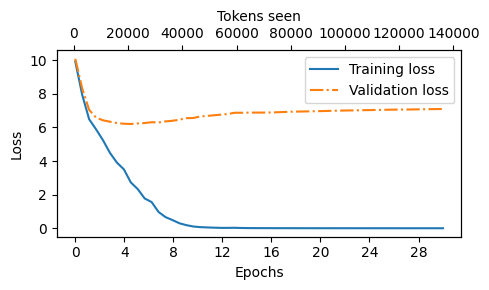

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Skip-connection intuition

In [39]:
# Function to compute gradients in the model's backward pass
def print_gradients(model, x):
    output = model(x)  # Forward pass
    target = torch.tensor([[0.]])
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)  # Calculates loss based on how close the target and output are
    loss.backward()  # Backward pass to calculate the gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:

            # run layer 
            layer_output = layer(x)

            # if skip connection, then you sum the original (x) + layer-output and feed to next network
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output

            # if no skip connection, then just layer_output = x, the input to next layer
            else:
                x = layer_output

        return x
    

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)

# Model without shortcut
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

# Call the function to print gradients
print("--model w/out shortcut--")
print_gradients(model_without_shortcut, sample_input)
print("\n\n--model w/ shortcut--")
print_gradients(model_with_shortcut, sample_input)


--model w/out shortcut--
layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


--model w/ shortcut--
layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846952389925718
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976
